# Import

In [314]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from datetime import timedelta
import seaborn as sns
import pickle 
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import json
from shapely.geometry import Point, Polygon


## Data Set

In [315]:
path_train = "/Users/patrickmacclenihan/Desktop/final_project/DATA/Train.csv"
path_test = "/Users/patrickmacclenihan/Desktop/final_project/DATA/Test.csv"
path_riders ="/Users/patrickmacclenihan/Desktop/final_project/DATA/Riders.csv"
df_train = pd.read_csv(path_train)
df_test = pd.read_csv(path_test)
df_riders = pd.read_csv(path_riders)


In [316]:
df_train.shape

(21201, 29)

In [317]:
df_train= pd.merge(df_train, df_riders , on = "Rider Id")
df_test= pd.merge(df_test, df_riders , on = "Rider Id")


In [318]:
df_train[["Pickup Lat", "Pickup Long", "Destination Lat", "Destination Long"]].head()

,Pickup Lat,Pickup Long,Destination Lat,Destination Long
0,-1.317755,36.830370,-1.300406,36.829741
1,-1.326774,36.787807,-1.356237,36.904295
2,-1.255189,36.782203,-1.273412,36.818206
3,-1.290315,36.757377,-1.223520,36.802061
4,-1.273524,36.799220,-1.300431,36.752427


# Preparation

## Converting to Date Time needed columns

In [319]:
time_to_convert_in_train = ["Confirmation - Time","Placement - Time",'Arrival at Pickup - Time',
       'Pickup - Time', 'Arrival at Destination - Time']

time_to_convert_in_test = ["Confirmation - Time","Placement - Time",'Arrival at Pickup - Time',
       'Pickup - Time']

for column in time_to_convert_in_train : 
    df_train[column] = df_train[column].apply(lambda x : pd.to_datetime(x).strftime('%H:%M:%S'))
    df_train[column] = pd.to_datetime(df_train[column], format='%H:%M:%S').dt.time

for column in time_to_convert_in_test :    
    
    df_test[column] = df_test[column].apply(lambda x : pd.to_datetime(x).strftime('%H:%M:%S'))
    df_test[column] = pd.to_datetime(df_test[column], format='%H:%M:%S').dt.time

In [320]:
#PickUp Hour
df_train['Pickup_Hour'] = df_train['Pickup - Time'].apply(lambda x : x.hour)

df_test['Pickup_Hour'] = df_test['Pickup - Time'].apply(lambda x : x.hour)


## Nan Values in Temperature

In [321]:
from sklearn.impute import KNNImputer

#KNN
KNN_imputer = KNNImputer(n_neighbors=10)

#On train
X_KNN = KNN_imputer.fit_transform(df_train[["Pickup_Hour", "Temperature"]])
df_train["Temperature"] = X_KNN[:,1]

#On test
X_KNN_test = KNN_imputer.transform(df_test[["Pickup_Hour", "Temperature"]])
df_test["Temperature"] = X_KNN_test[:,1]



In [323]:
df_train.isna().sum()

Order No                                         0
User Id                                          0
Vehicle Type                                     0
Platform Type                                    0
Personal or Business                             0
Placement - Day of Month                         0
Placement - Weekday (Mo = 1)                     0
Placement - Time                                 0
Confirmation - Day of Month                      0
Confirmation - Weekday (Mo = 1)                  0
Confirmation - Time                              0
Arrival at Pickup - Day of Month                 0
Arrival at Pickup - Weekday (Mo = 1)             0
Arrival at Pickup - Time                         0
Pickup - Day of Month                            0
Pickup - Weekday (Mo = 1)                        0
Pickup - Time                                    0
Arrival at Destination - Day of Month            0
Arrival at Destination - Weekday (Mo = 1)        0
Arrival at Destination - Time  

## Dropping Duplicates

In [324]:
df_train.drop_duplicates(inplace= True )
df_test.drop_duplicates(inplace= True )


## Remove Speed Outliers

In [325]:
df_train["Speed_in_km/h"] = df_train["Distance (KM)"] / df_train['Time from Pickup to Arrival']*3600 

In [326]:
df_train["Speed_in_km/h"]

0        19.328859
1        24.948025
2         8.260038
3        21.701273
4        15.730337
           ...    
21196    11.751904
21197     9.266409
21198    10.421836
21199    10.041841
21200    21.857923
Name: Speed_in_km/h, Length: 21201, dtype: float64

In [327]:
def error_detection(x) : 
    if x > 50 or x < 5 : 
        return "Yes"
    else : 
        return "No"

df_train["Overspeed"] = df_train["Speed_in_km/h"].apply(lambda x : error_detection(x))

In [328]:
df_train["Overspeed"].unique()

array(['No', 'Yes'], dtype=object)

In [329]:
df_train_withoutliers = df_train[df_train["Overspeed"] == "No"]
df_train_withoutliers.drop("Overspeed" , axis = 1 , inplace = True )

/Users/patrickmacclenihan/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


## Object columns to convert int / float

In [330]:
to_convert = ["Placement - Time","Confirmation - Time", "Arrival at Pickup - Time",       
              "Pickup - Time"]  

### Make Binary

In [331]:
def binary_personnal_business(x) : 
    if x == "Personal" : 
        return  1 
    else : 
        return  0 

In [332]:
df_train_withoutliers['Personal or Business'] = df_train_withoutliers['Personal or Business'].apply(binary_personnal_business)
df_test['Personal or Business'] = df_test['Personal or Business'].apply(binary_personnal_business)


/Users/patrickmacclenihan/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [333]:
#Reassigning
df_train_numerical = df_train_withoutliers
df_test_numerical  = df_test

# Features Engineering

## Week-End Feature

In [334]:
def is_week_end(x): 
    if x > 5 : 
        return 1
    else :
        return 0
    
df_train_numerical["Week_end"] = df_train_numerical["Placement - Weekday (Mo = 1)"].apply(is_week_end)
df_test_numerical["Week_end"] = df_test_numerical["Placement - Weekday (Mo = 1)"].apply(is_week_end)

/Users/patrickmacclenihan/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


## Uber Data

### Import

In [335]:

with open('/Users/patrickmacclenihan/Desktop/final_project/DATA/Uber/nairobi_sublocations.json') as json_file:
    data = json.load(json_file)

In [336]:
#Gathering Movments Id and Areas
areas,ids,polygons = [],[],[]
for d in range(len(data["features"])) : 
    areas.append(data["features"][d]["properties"]["DISPLAY_NAME"])
    ids.append(data["features"][d]["properties"]["MOVEMENT_ID"])
    #polygons.append(data["features"][d]["geometry"]["coordinates"])

#Gathering Polygons

for d in range(len(data["features"])) : 
    coord = []
    polygons.append(coord)
    for i in range(len(data["features"][d]["geometry"]["coordinates"][0])) : 
        coord_tuple = data["features"][d]["geometry"]["coordinates"][0][i]
        coord.append(coord_tuple)


### Defining PickUp and Destination Id 

In [337]:
def uber_movement_id(longitude, lattitude) : 
    point = Point(longitude, lattitude)
    for i in range(len(polygons)): 
        if point.within(Polygon(polygons[i])) == True : 
            return int(ids[i])
        
        if point.within(Polygon(polygons[i])) == False : 
            distances = []
            for i in range(len(polygons)): 
                distances.append(Polygon(polygons[i]).distance(point))
            
            polygon_id = distances.index(min(distances))
            return  polygon_id+1
        
            

def merge_pickup_lat_long_cols(series): 
    return (series['Pickup Long'], series['Pickup Lat'])
def merge_destination_lat_long_cols(series): 
    return (series['Destination Long'], series['Destination Lat'])


### Adding Uber Features to Train
df_train_numerical['pickup_long_lat']= df_train_numerical.apply(merge_pickup_lat_long_cols, axis=1)
df_train_numerical['destination_long_lat']= df_train_numerical.apply(merge_destination_lat_long_cols, axis=1)

df_train_numerical["Pickup_Id"] = df_train_numerical['pickup_long_lat'].apply(lambda x : uber_movement_id(x[0],x[1]))
df_train_numerical["Destination_Id"] = df_train_numerical['destination_long_lat'].apply(lambda x : uber_movement_id(x[0],x[1]))

df_train_numerical["Pickup_Id"].isna().sum(), df_train_numerical["Destination_Id"].isna().sum() #,df_train["Destination_Id"].isna().sum()  



### Adding Uber Features to Test

df_test_numerical['pickup_long_lat']= df_test_numerical.apply(merge_pickup_lat_long_cols, axis=1)
df_test_numerical['destination_long_lat']= df_test_numerical.apply(merge_destination_lat_long_cols, axis=1)

df_test_numerical["Pickup_Id"] = df_test_numerical['pickup_long_lat'].apply(lambda x : uber_movement_id(x[0],x[1]))
df_test_numerical["Destination_Id"] = df_test_numerical['destination_long_lat'].apply(lambda x : uber_movement_id(x[0],x[1]))


/Users/patrickmacclenihan/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/patrickmacclenihan/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/patrickmacclenihan/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

In [338]:
df_test_numerical["Pickup_Id"].nunique()

85

### Adding Hourly Travel Time for Week-Day & WeekEnd 

In [339]:
import pickle
df_speed = pickle.load( open( "/Users/patrickmacclenihan/Final_Project_Viva_Data_2020/travel_time", "rb" ) )

In [340]:
#CREATION OF UBER Df

#MEAN TRAVEL TIME 
#aggregation per source & destination ids, hour of the day and week end or not)
grouped_multiple_speed_uber = df_speed.groupby(["sourceid","dstid","hod", "week_end_or_not"]).agg({"mean_travel_time": ['mean']})
grouped_multiple_speed_uber.columns = ['mean_travel_time']
grouped_multiple_speed_uber = grouped_multiple_speed_uber.reset_index()
grouped_multiple_speed_uber.head()                                

#STD TRAVEL TIME 
#aggregation per source & destination ids, hour of the day and week end or not)
grouped_std_time_uber = df_speed.groupby(["sourceid","dstid","hod", "week_end_or_not"]).agg({"standard_deviation_travel_time": ['mean']})
grouped_std_time_uber.columns = ['std_travel_time']
grouped_std_time_uber =grouped_std_time_uber.reset_index()

#UBER DF CREATION
#Merging to get one Uber dataFrame 
df_uber = pd.merge(grouped_std_time_uber, grouped_multiple_speed_uber,  
                  how='left', 
                  left_on=["sourceid","dstid", "hod","week_end_or_not" ], 
                  right_on = ["sourceid","dstid", "hod","week_end_or_not"]
                 )


                                

### Mean Travel Time 

In [341]:
#Merging Train to Uber to add mean_travel_time
df_train_with_uber = pd.merge(df_train_numerical, df_uber,  
                  how='left', 
                  left_on=['Pickup_Hour','Week_end', "Pickup_Id" , "Destination_Id"], 
                  right_on = ["hod","week_end_or_not", "sourceid" , "dstid"]
                 )

#Merging Test to Uber to add mean_travel_time 
df_test_with_uber = pd.merge(df_test_numerical, df_uber,  
                  how='left', 
                  left_on=['Pickup_Hour','Week_end', "Pickup_Id" , "Destination_Id"], 
                  right_on = ["hod","week_end_or_not", "sourceid" , "dstid"]
                 )


In [395]:
df_train_with_uber[df_train_with_uber["sourceid"].isna() == True ]

,Order No,User Id,Vehicle Type,Platform Type,Personal or Business,Placement - Day of Month,Placement - Weekday (Mo = 1),Placement - Time,Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),...,pickup_long_lat,destination_long_lat,Pickup_Id,Destination_Id,sourceid,dstid,hod,week_end_or_not,std_travel_time,mean_travel_time
44,Order_No_53,User_Id_1926,Bike,3,0,6,4,10:10:37,6,4,...,"(36.8925345, -1.34364)","(36.9076533, -1.3065588)",76,76,NaN,NaN,NaN,NaN,NaN,NaN
66,Order_No_1899,User_Id_265,Bike,3,0,30,2,12:39:25,30,2,...,"(36.843419399999995, -1.3082842)","(36.828195, -1.300921)",81,81,NaN,NaN,NaN,NaN,NaN,NaN
137,Order_No_12429,User_Id_136,Bike,3,0,11,2,13:51:40,11,2,...,"(36.7445491, -1.3360945)","(36.721658399999995, -1.3254522)",91,91,NaN,NaN,NaN,NaN,NaN,NaN
182,Order_No_26059,User_Id_3517,Bike,3,0,30,2,12:59:15,30,2,...,"(36.808679600000005, -1.2546732)","(36.799343900000004, -1.2599563)",28,28,NaN,NaN,NaN,NaN,NaN,NaN
204,Order_No_16321,User_Id_1642,Bike,3,0,27,3,13:59:08,27,3,...,"(36.7960153, -1.2726506000000002)","(36.7796691, -1.2789469)",48,48,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19637,Order_No_20326,User_Id_552,Bike,3,0,18,4,12:05:26,18,4,...,"(36.930829700000004, -1.335477)","(36.904295399999995, -1.3562374)",76,76,NaN,NaN,NaN,NaN,NaN,NaN
19659,Order_No_3409,User_Id_3283,Bike,3,0,7,2,14:39:57,7,2,...,"(36.799248999999996, -1.266837)","(36.781805, -1.2628473)",40,40,NaN,NaN,NaN,NaN,NaN,NaN
19660,Order_No_21249,User_Id_640,Bike,3,0,22,4,10:59:18,22,4,...,"(36.7848695, -1.304033)","(36.790159100000004, -1.3004846)",90,90,NaN,NaN,NaN,NaN,NaN,NaN
19667,Order_No_7005,User_Id_2358,Bike,4,0,11,3,08:39:18,11,3,...,"(36.8747943, -1.3256903999999998)","(36.8617394, -1.3256159)",99,99,NaN,NaN,NaN,NaN,NaN,NaN


### Minimum Travel Time

In [342]:
#df Minimum travel time per sourceid
closest_area = df_speed.groupby(["sourceid","hod", "week_end_or_not"]).agg({"mean_travel_time": ['min']})
closest_area.columns = ['min_travel_time']
closest_area = closest_area.reset_index()



In [399]:
closest_area_for_std = df_speed.groupby(["sourceid","hod", "week_end_or_not"]).agg({"standard_deviation_travel_time": ['min']})
closest_area_for_std.columns = ['min_std_travel_time']
closest_area_for_std = closest_area_for_std.reset_index()


In [404]:
## TRAIN
#Merging Train with Minimum Travel Time by UBER for same sourceid et dstid
df_train_with_speeds = pd.merge(df_train_with_uber, closest_area,  
                  how='left', 
                  left_on=['Pickup_Hour','Week_end', "Pickup_Id" ], 
                  right_on = ['hod', "week_end_or_not", "sourceid"]
                 )

df_train_with_speeds = pd.merge(df_train_with_speeds, closest_area_for_std,  
                  how='left', 
                  left_on=['Pickup_Hour','Week_end', "Pickup_Id" ], 
                  right_on = ['hod', "week_end_or_not", "sourceid"]
                 )


#Replacing NA mean travel time by Min speed
df_train_with_speeds["mean_travel_time"].fillna(df_train_with_speeds['min_travel_time'], inplace = True )
df_train_with_speeds["std_travel_time"].fillna(df_train_with_speeds['min_std_travel_time'], inplace = True )




In [410]:
## TEST
#Merging TESt with Minimum Travel Time by UBER for same sourceid et dstid
df_test_with_speeds = pd.merge(df_test_with_uber, closest_area,  
                  how='left', 
                  left_on=['Pickup_Hour','Week_end', "Pickup_Id" ], 
                  right_on = ['hod', "week_end_or_not", "sourceid"])

df_test_with_speeds = pd.merge(df_test_with_speeds, closest_area_for_std,  
                  how='left', 
                  left_on=['Pickup_Hour','Week_end', "Pickup_Id" ], 
                  right_on = ['hod', "week_end_or_not", "sourceid"]
                 )


#Replacing NA mean travel time by Min speed
df_test_with_speeds["mean_travel_time"].fillna(df_test_with_speeds['min_travel_time'], inplace = True )
df_test_with_speeds["std_travel_time"].fillna(df_test_with_speeds['min_std_travel_time'], inplace = True )


Some PickUpId & Destination Id are equal - so no mean_Travel_time value - so we took closest one

In [411]:
#Reassigning
df_train_uber_clean = df_train_with_speeds  
df_test_uber_clean = df_test_with_speeds

## Adding Cluster for PickUp and Drop Off 

### Finding optimal nulmber of clusters

In [412]:
cost_pickup = []
for i in range(60):
    kmeans = MiniBatchKMeans(n_clusters=i+1,batch_size=1000, random_state= 52)
    kmeans.fit(df_train_uber_clean[['Pickup Lat', 'Pickup Long']])
    cost_pickup.append(kmeans.inertia_)

In [413]:
cost_dropoff = []
for i in range(60):
    kmeans = MiniBatchKMeans(n_clusters=i+1,batch_size=1000, random_state= 52)
    kmeans.fit(df_train_uber_clean[['Destination Lat', 'Destination Long']])
    cost_dropoff.append(kmeans.inertia_)

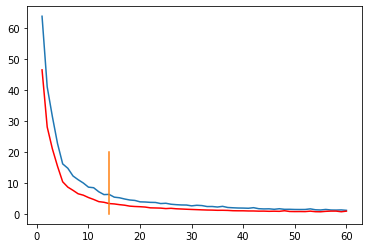

In [414]:
plt.plot(np.arange(1, 61, 1), cost_dropoff)
plt.plot(np.arange(1, 61, 1), cost_pickup, color = "red")
plt.plot([14,14] , [0,20])
plt.show()

In [415]:
pick_up_mn_kmeans = MiniBatchKMeans(n_clusters= 14 ,batch_size=1000, random_state= 52)
pickup_clusters = pick_up_mn_kmeans.fit(df_train_uber_clean[['Pickup Lat', 'Pickup Long']])
drop_mn_kmeans = MiniBatchKMeans(n_clusters= 14 ,batch_size=1000, random_state= 52)
drop_clusters = drop_mn_kmeans.fit(df_train_uber_clean[['Destination Lat', 'Destination Long']])




### Clustering Train 

In [416]:
drop_clusters = (drop_clusters.labels_).reshape(-1,1).astype(object)
pickup_clusters = (pickup_clusters.labels_).reshape(-1,1).astype(object)

destination_clusters = pd.DataFrame(drop_clusters, columns = ["destination_clusters"])
pickup_clusters = pd.DataFrame(pickup_clusters, columns = ["pickup_clusters"])


df_train_with_labels = pd.concat([df_train_uber_clean,destination_clusters, pickup_clusters], axis = 1)

### Clustering Test

In [417]:
#Predicting clusters labels 
test_pickup_labels =pd.DataFrame(pick_up_mn_kmeans.predict(df_test_uber_clean[['Pickup Lat', 'Pickup Long']]).reshape(-1,1).astype(str) ,  columns = ["pickup_clusters"])
test_drop_labels = pd.DataFrame(drop_mn_kmeans .predict(df_test_uber_clean[['Destination Lat', 'Destination Long']]).reshape(-1,1).astype(str), columns = ["destination_clusters"])

#Merging 
df_test_with_labels = pd.concat([df_test_uber_clean,test_drop_labels, test_pickup_labels], axis = 1)


### PCA

In [418]:
coords = np.vstack((df_train_with_labels[['Pickup Lat', 'Pickup Long']].values,
                    df_train_with_labels[['Destination Lat', 'Destination Long']].values))

In [419]:
pca = PCA(random_state=42).fit(coords)

In [420]:
pca = PCA(random_state=50).fit(coords)

df_train_with_labels['pickup_pca0'] = pca.transform(df_train_with_labels[['Pickup Lat', 'Pickup Long']])[:, 0]
df_train_with_labels['pickup_pca1'] = pca.transform(df_train_with_labels[['Pickup Lat', 'Pickup Long']])[:, 1]
df_train_with_labels['dropoff_pca0'] = pca.transform(df_train_with_labels[['Destination Lat', 'Destination Long']])[:, 0]
df_train_with_labels['dropoff_pca1'] = pca.transform(df_train_with_labels[['Destination Lat', 'Destination Long']])[:, 1]
df_test_with_labels['pickup_pca0'] = pca.transform(df_test_with_labels[['Pickup Lat', 'Pickup Long']])[:, 0]
df_test_with_labels['pickup_pca1'] = pca.transform(df_test_with_labels[['Pickup Lat', 'Pickup Long']])[:, 1]
df_test_with_labels['dropoff_pca0'] = pca.transform(df_test_with_labels[['Destination Lat', 'Destination Long']])[:, 0]
df_test_with_labels['dropoff_pca1'] = pca.transform(df_test_with_labels[['Destination Lat', 'Destination Long']])[:, 1]


## Rush Hours

In [421]:
#Train
df_train_with_labels['Rush_Hour'] = df_train_with_labels ["Pickup_Hour"].apply(lambda x : "Yes" if (x>6 and x<9) or (x>16 and x<19) else "No")

#Test
df_test_with_labels['Rush_Hour'] = df_test_with_labels["Pickup_Hour"].apply(lambda x : "Yes" if (x>6 and x<9) or (x>16 and x<19) else "No")


## Riders and Ratings 

In [422]:
df_train_with_labels['Average_Rider_Speed'] = df_train_with_labels['Rider Id'].map(df_train_with_labels.groupby('Rider Id')["Speed_in_km/h"].mean())


In [423]:
df_test_with_labels["Average_Rider_Speed"] = df_test_with_labels["Rider Id"].map(df_train_with_labels.groupby('Rider Id')["Speed_in_km/h"].mean())



# Dummies and scaling 

## Dummies



In [555]:
df_train_dummies = df_train_with_labels 
df_test_dummies =  df_test_with_labels

### Dummies on Train

In [556]:
train_platform_dummies = pd.get_dummies(df_train_dummies['Platform Type'],prefix='Platform Type', drop_first='True')
train_personnal_business_dummies = pd.get_dummies(df_train_dummies['Personal or Business'],prefix='Personal or Business', drop_first='True')
train_monthday_dummies = pd.get_dummies(df_train_dummies['Placement - Day of Month'],prefix='Placement - Day of Month', drop_first='True')
train_pickup_hour_dummies = pd.get_dummies(df_train_dummies['Pickup_Hour'],prefix='Pickup_Hour', drop_first='True')
train_pickup_id_dummies = pd.get_dummies(df_train_dummies['Pickup_Id'],prefix='Pickup_Id', drop_first='True')
train_destination_id_dummies = pd.get_dummies(df_train_dummies['Destination_Id'],prefix='Destination_Id', drop_first='True')
train_week_end_dummies = pd.get_dummies(df_train_dummies["Week_end"],prefix='Week_end', drop_first='True')
train_destination_dummies = pd.get_dummies(df_train_dummies["destination_clusters"],prefix='destination_clusters', drop_first='True')
train_pick_up_dummies = pd.get_dummies(df_train_dummies["pickup_clusters"],prefix='pickup_clusters', drop_first='True')
train_rush_hours_dummies = pd.get_dummies(df_train_dummies["Rush_Hour"],prefix='Rush_Hour', drop_first='True')
train_week_day_dummies = pd.get_dummies(df_train_dummies["Placement - Weekday (Mo = 1)"],prefix='Placement - Weekday (Mo = 1)', drop_first='True')




df_train_dummies = pd.concat([df_train_dummies, 
                        train_platform_dummies, train_personnal_business_dummies, 
                        train_monthday_dummies,train_pickup_hour_dummies, train_pickup_id_dummies,
                        train_destination_id_dummies, train_week_end_dummies,
                        train_destination_dummies,train_pick_up_dummies, train_rush_hours_dummies,
                        train_week_day_dummies       
                        ], axis=1)






In [557]:
df_train_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19693 entries, 0 to 19692
Columns: 337 entries, Order No to Placement - Weekday (Mo = 1)_7
dtypes: float64(21), int64(27), object(14), uint8(275)
memory usage: 14.6+ MB


### Dummies on Test

In [558]:
test_platform_dummies = pd.get_dummies(df_test_dummies['Platform Type'],prefix='Platform Type', drop_first='True')
test_personnal_business_dummies = pd.get_dummies(df_test_dummies['Personal or Business'],prefix='Personal or Business', drop_first='True')
test_monthday_dummies = pd.get_dummies(df_test_dummies['Placement - Day of Month'],prefix='Placement - Day of Month', drop_first='True')
test_pickup_hour_dummies = pd.get_dummies(df_test_dummies['Pickup_Hour'],prefix='Pickup_Hour', drop_first='True')
test_pickup_id_dummies = pd.get_dummies(df_test_dummies['Pickup_Id'],prefix='Pickup_Id', drop_first='True')
test_destination_id_dummies = pd.get_dummies(df_test_dummies['Destination_Id'],prefix='Destination_Id', drop_first='True')
test_week_end_dummies = pd.get_dummies(df_test_dummies["Week_end"],prefix='Week_end', drop_first='True')
test_destination_dummies = pd.get_dummies(df_test_dummies["destination_clusters"],prefix='destination_clusters', drop_first='True')
test_pick_up_dummies = pd.get_dummies(df_test_dummies["pickup_clusters"],prefix='pickup_clusters', drop_first='True')
test_rush_hours_dummies = pd.get_dummies(df_test_dummies["Rush_Hour"],prefix='Rush_Hour', drop_first='True')
test_week_day_dummies = pd.get_dummies(df_test_dummies["Placement - Weekday (Mo = 1)"],prefix='Placement - Weekday (Mo = 1)', drop_first='True')


df_test_dummies = pd.concat([df_test_with_labels, 
                        test_platform_dummies, test_personnal_business_dummies, 
                        test_monthday_dummies,test_pickup_hour_dummies, test_pickup_id_dummies,
                        test_destination_id_dummies, test_week_end_dummies,test_destination_dummies,test_pick_up_dummies,
                        test_rush_hours_dummies, test_week_day_dummies
                        ], axis=1)



In [559]:
df_test_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7068 entries, 0 to 7067
Columns: 318 entries, Order No to Placement - Weekday (Mo = 1)_7
dtypes: float64(20), int64(24), object(13), uint8(261)
memory usage: 5.2+ MB


In [560]:
for i in df_test_dummies : 
    if i not in df_train_dummies : 
        print(i)
print('-----')


for i in  df_train_dummies : 
    if i not in df_test_dummies : 
        print(i)

Pickup_Id_33
Pickup_Id_51
Pickup_Id_56
Pickup_Id_59
Pickup_Id_78
Destination_Id_16
Destination_Id_20
Destination_Id_72
-----
Arrival at Destination - Day of Month
Arrival at Destination - Weekday (Mo = 1)
Arrival at Destination - Time
Time from Pickup to Arrival
Speed_in_km/h
Pickup_Hour_22
Pickup_Id_3
Pickup_Id_4
Pickup_Id_31
Pickup_Id_32
Pickup_Id_36
Pickup_Id_63
Pickup_Id_67
Pickup_Id_71
Pickup_Id_72
Pickup_Id_79
Pickup_Id_105
Destination_Id_21
Destination_Id_31
Destination_Id_35
Destination_Id_37
Destination_Id_56
Destination_Id_66
Destination_Id_67
Destination_Id_69
Destination_Id_71
Destination_Id_74


## Scaling

In [561]:
scaler = StandardScaler()

columns_to_scale =[
   "Distance (KM)","Temperature","Pickup Lat","Pickup Long","Destination Lat","Destination Long" ,
    "No_Of_Orders","Age","Average_Rating","mean_travel_time", "Average_Rider_Speed"] 

In [562]:
#Train 
scaler_train = scaler.fit(df_train_dummies[columns_to_scale])
df_train_dummies[columns_to_scale] = scaler_train.transform(df_train_dummies[columns_to_scale])

In [563]:
df_train_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19693 entries, 0 to 19692
Columns: 337 entries, Order No to Placement - Weekday (Mo = 1)_7
dtypes: float64(24), int64(24), object(14), uint8(275)
memory usage: 14.6+ MB


In [564]:
#Test
df_test_dummies[columns_to_scale] = scaler_train.transform(df_test_dummies[columns_to_scale])
df_test_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7068 entries, 0 to 7067
Columns: 318 entries, Order No to Placement - Weekday (Mo = 1)_7
dtypes: float64(23), int64(21), object(13), uint8(261)
memory usage: 5.2+ MB


In [565]:
df_test_to_drop = df_test_dummies 
df_train_to_drop = df_train_dummies 

In [566]:
for i in df_test_to_drop : 
    if i not in df_train_to_drop : 
        print(i)
print('-----')


for i in  df_train_to_drop : 
    if i not in df_test_to_drop : 
        print(i)

Pickup_Id_33
Pickup_Id_51
Pickup_Id_56
Pickup_Id_59
Pickup_Id_78
Destination_Id_16
Destination_Id_20
Destination_Id_72
-----
Arrival at Destination - Day of Month
Arrival at Destination - Weekday (Mo = 1)
Arrival at Destination - Time
Time from Pickup to Arrival
Speed_in_km/h
Pickup_Hour_22
Pickup_Id_3
Pickup_Id_4
Pickup_Id_31
Pickup_Id_32
Pickup_Id_36
Pickup_Id_63
Pickup_Id_67
Pickup_Id_71
Pickup_Id_72
Pickup_Id_79
Pickup_Id_105
Destination_Id_21
Destination_Id_31
Destination_Id_35
Destination_Id_37
Destination_Id_56
Destination_Id_66
Destination_Id_67
Destination_Id_69
Destination_Id_71
Destination_Id_74


# Dropping Columns

## Train

In [567]:
columns_to_drop_in_train = [
"Order No",
'User Id',
'Vehicle Type',
'Confirmation - Day of Month', 
'Confirmation - Weekday (Mo = 1)',
'Arrival at Pickup - Day of Month',
'Arrival at Pickup - Weekday (Mo = 1)',
'Pickup - Day of Month',
'Pickup - Weekday (Mo = 1)',
"Precipitation in millimeters",
'Arrival at Destination - Day of Month',
'Arrival at Destination - Weekday (Mo = 1)',
"Arrival at Destination - Time",
"Rider Id", 
"Speed_in_km/h",
"Platform Type", 
"Personal or Business", 
"Placement - Day of Month", 
"Pickup_Hour" ,
"Week_end",
"Pickup_Id" ,
"Destination_Id",
"destination_clusters",
"pickup_clusters", 
'Rush_Hour',
"sourceid_x",
"hod_x",
"week_end_or_not_x",
"sourceid_y",
"hod_y",
"week_end_or_not_y",
"pickup_long_lat",
'destination_long_lat',
'Placement - Time', 
'Confirmation - Time', 
'Arrival at Pickup - Time', 
'Pickup - Time',
"min_travel_time",
"min_std_travel_time",
"hod",
"Placement - Weekday (Mo = 1)",
'Pickup Lat',
 'Pickup Long',
 'Destination Lat',
 'Destination Long']



In [568]:
df_train_to_drop.drop(columns_to_drop_in_train , axis = 1 , inplace = True )

In [569]:
columns_to_drop_in_test = [
"Order No", 
'User Id', 
'Vehicle Type', 
'Confirmation - Day of Month', 
'Confirmation - Weekday (Mo = 1)',
'Arrival at Pickup - Day of Month',
'Arrival at Pickup - Weekday (Mo = 1)',
'Pickup - Day of Month',
'Pickup - Weekday (Mo = 1)',
"Precipitation in millimeters",
"Rider Id", 
"Platform Type",
"Personal or Business", 
"Placement - Day of Month", 
"Pickup_Hour",
"Week_end",
"Pickup_Id",
"Destination_Id",
"destination_clusters",
"pickup_clusters", 
'Rush_Hour',
"sourceid_x",
"hod_x",
"week_end_or_not_x",
"sourceid_y",
"hod_y",
"week_end_or_not_y",
"pickup_long_lat",
"destination_long_lat",
'Placement - Time', 
'Confirmation - Time', 
'Arrival at Pickup - Time', 
'Pickup - Time',
"min_travel_time",
"min_std_travel_time",
"hod",
"Placement - Weekday (Mo = 1)",
'Pickup Lat',
 'Pickup Long',
 'Destination Lat',
 'Destination Long']   


In [570]:
df_test_to_drop.drop(columns_to_drop_in_test , axis = 1 , inplace = True ) 

In [571]:
to_add_in_train = []
to_add_in_test = []

for i in df_test_to_drop : 
    if i not in df_train_to_drop : 
        print(i)
        to_add_in_train.append(i)
print('-----')


for i in  df_train_to_drop : 
    if i not in df_test_to_drop : 
        print(i)
        to_add_in_test.append(i)

Pickup_Id_33
Pickup_Id_51
Pickup_Id_56
Pickup_Id_59
Pickup_Id_78
Destination_Id_16
Destination_Id_20
Destination_Id_72
-----
Time from Pickup to Arrival
Pickup_Hour_22
Pickup_Id_3
Pickup_Id_4
Pickup_Id_31
Pickup_Id_32
Pickup_Id_36
Pickup_Id_63
Pickup_Id_67
Pickup_Id_71
Pickup_Id_72
Pickup_Id_79
Pickup_Id_105
Destination_Id_21
Destination_Id_31
Destination_Id_35
Destination_Id_37
Destination_Id_56
Destination_Id_66
Destination_Id_67
Destination_Id_69
Destination_Id_71
Destination_Id_74


In [572]:
print(len(to_add_in_test))
to_add_in_test.remove("Time from Pickup to Arrival")
print(len(to_add_in_test))

23
22


# Adding Columns 

## Test

In [573]:
for col in to_add_in_test : 
    df_test_to_drop[col] = 0
df_test_to_drop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7068 entries, 0 to 7067
Columns: 299 entries, Distance (KM) to Destination_Id_74
dtypes: float64(13), int64(25), uint8(261)
memory usage: 4.2 MB


In [574]:
for col in to_add_in_train : 
    df_train_to_drop[col] = 0
df_train_to_drop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19693 entries, 0 to 19692
Columns: 300 entries, Distance (KM) to Destination_Id_72
dtypes: float64(13), int64(12), uint8(275)
memory usage: 9.1 MB


In [575]:
categorical = [var for var in df_train_to_drop.columns if df_train_to_drop[var].dtype=='O']
print('There are {} categorical variables\n'.format(len(categorical)))
print("Categorical variables are  : \n", categorical)

There are 0 categorical variables

Categorical variables are  : 
 []


# Save Data as Pickle

In [584]:
pickle.dump(df_train_to_drop, open("/Users/patrickmacclenihan/Desktop/final_project/JP notebooks/train_data_ready", "wb"))
pickle.dump(df_test_to_drop , open("test_data_ready", "wb"))

In [578]:
columns = list()
for i in df_train_to_drop : 
    columns.append(i)

In [579]:
pickle.dump(columns , open("/Users/patrickmacclenihan/Desktop/final_project/DATA/columns", "wb"))

In [583]:
columns_to_drop_in_train
pickle.dump(columns_to_drop_in_train , open("/Users/patrickmacclenihan/Desktop/final_project/DATA/columns_to_drop", "wb"))